In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import analyze # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm
import datetime


%matplotlib inline

Using TensorFlow backend.


In [2]:
#make runlists
from make_runlist_new import write_spe_lists
# dry run
write_spe_lists(write=False)

1045
cursor has 1045 runs
Number of runs and most recent run of each type
blank 31 15986
bottom 31 15987
topbulk 31 15988
topring 31 15989
15986 15987 15988 15989


In [3]:
# if happy with dry run, write the files
wrote = write_spe_lists(write=True)
print("We wrote these files:")
for f in wrote:
    print('\t' + f)

1045
Number of runs and most recent run of each type
blank 31 15986
bottom 31 15987
topbulk 31 15988
topring 31 15989
We wrote these files:
	./runlists/runlist_15987_15988_15989.txt


In [4]:
#write runlists to files to be submitted 
with open("tmp_submit_file.txt", "w") as f:
    for file in wrote:
        f.write("%s\n" % file)

In [5]:
#submit runlists to midway
%%bash

./notebook_submit.sh

SyntaxError: invalid syntax (<ipython-input-5-2b368e6015b5>, line 2)

In [2]:
ACTUALLY_OFF = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 
                130, 134, 135, 139, 148, 150, 152, 162, 178, 183,
                190, 198, 206, 213, 214, 234, 239, 244]

In [3]:
#takes runlists and uses just bottom runs 
#finds acceptances and errors

def data_exists(run_number):
    return os.path.exists('./data/run_%05d.h5' % run_number)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

runlists = [f for f in os.listdir('./runlists')]

bottom_runs = []
accs = []
errors = []

missing_runs = []

for f in tqdm(sorted(runlists)):
    runlist = file_to_list(f)
    if not all_data_exists(runlist):
        #print('data missing for %s' % f)
        for r in runlist:
            if not data_exists(r):
                missing_runs.append(r)
        continue
    bottom_run = runlist[0]
    topbulk_run = runlist[1]
    topring_run = runlist[2]
    
    thresholds = analyze.get_thresholds(analyze.find_regular_run(bottom_run))
    
    acc, acc_errs = analyze.acceptance_3runs(bottom_run, topbulk_run, topring_run, thresholds)
    occ, occ_errs = analyze.occupancy_3runs(bottom_run, topbulk_run, topring_run)
    
    on_channels = np.where(occ > 0.05)[0]
    
    if len(on_channels) < 200:
        print('LED likely OFF for %s' % f)
        continue
    
    acc = acc[on_channels]
    acc_errs = acc_errs[on_channels]
    
    accs.append(np.median(acc))
    errors.append(np.sqrt((acc_errs**2).sum()) / len(on_channels))
    bottom_runs.append(bottom_run)
    

 18%|█▊        | 18/101 [01:38<08:06,  5.86s/it]/home/awalsh272/SPE/SPE/analyze.py:63: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
/home/awalsh272/SPE/SPE/analyze.py:63: RuntimeWarning: invalid value encountered in true_divide
  return 1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
 29%|██▊       | 29/101 [02:47<07:44,  6.45s/it]

LED likely OFF for runlist_13433_13434_13435.txt


 32%|███▏      | 32/101 [03:07<07:03,  6.14s/it]

LED likely OFF for runlist_14088_14089_14090.txt


 54%|█████▍    | 55/101 [04:23<04:33,  5.95s/it]/home/awalsh272/SPE/SPE/analyze.py:31: RuntimeWarning: divide by zero encountered in log
  occupancy_array[:,i] = -1*np.log(self.make_correction(val, 'amplitude'))
100%|██████████| 101/101 [08:25<00:00,  5.29s/it]


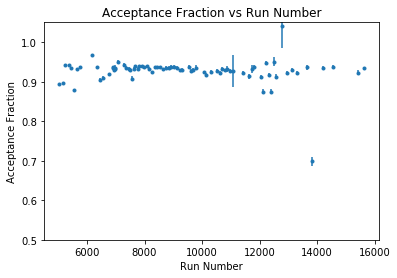

In [4]:
#acceptance vs run number 
plt.errorbar(bottom_runs, accs, yerr=errors, linestyle='None', marker='.')
plt.xlabel("Run Number")
plt.ylabel("Acceptance Fraction")
plt.ylim(0.5, 1.05)
plt.title("Acceptance Fraction vs Run Number")
plt.show()

In [9]:
#make a dictionary of runs and dates
from make_runlist_new import get_dates
date_dict=get_dates(bottom_runs)

date_list=[]

#list of ordered dates

for i in date_dict.values():
    #turn dates into strings
    i=datetime.datetime.strftime(i, '%x')
    #so they can be reformated as dates again
    i=datetime.datetime.strptime(i, '%x')
    date_list.append(i)

dates=sorted(date_list)

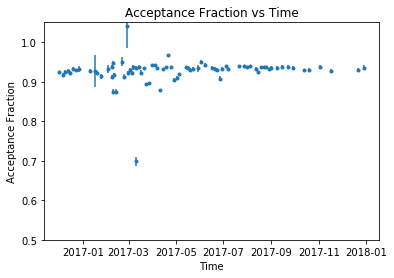

In [10]:
#plot acceptances vs time

plt.errorbar(dates, accs, yerr=errors, linestyle='None', marker='.')
plt.xlabel("Time")
plt.ylabel("Acceptance Fraction")
plt.ylim(0.5, 1.05)
plt.title("Acceptance Fraction vs Time")
plt.show()